## **0. Install Required Libraries**


In [78]:
# !pip install numpy==1.23.5
# !pip install --upgrade gensim
# !pip install --upgrade pythainlp
# !pip install emoji
# !pip install fastapi uvicorn joblib  # เพิ่มสำหรับ FastAPI และการรัน API

## **1. Import Libraries**


In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import string
import emoji
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_negations, thai_stopwords
from pythainlp.word_vector import WordVector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack, csr_matrix
from collections import Counter
import joblib
import os
from matplotlib import font_manager, rcParams
from fastapi import FastAPI, HTTPException  # เพิ่มสำหรับ FastAPI
from pydantic import BaseModel  # เพิ่มสำหรับกำหนดโครงสร้างข้อมูล
from wordcloud import WordCloud
from nltk import ngrams  # เพิ่มบรรทัดนี้
from pythainlp.tokenize import word_tokenize

In [80]:
# path ฟอนต์ Noto Sans Thai (ตามที่คุณแนบ)
THAI_FONT_PATH = r"C:\Users\Phutawan Chonsakorn\AppData\Local\Microsoft\Windows\Fonts\NotoSansThai-VariableFont_wdth,wght.ttf"

# ตรวจสอบว่ามีไฟล์จริง
if os.path.exists(THAI_FONT_PATH):
    font_manager.fontManager.addfont(THAI_FONT_PATH)
    font_name = font_manager.FontProperties(fname=THAI_FONT_PATH).get_name()
    rcParams["font.family"] = font_name
    rcParams["font.sans-serif"] = [font_name]
    rcParams["axes.unicode_minus"] = False  # ให้แสดงเครื่องหมายลบได้ถูกต้อง
    print(f"✅ Using Thai font: {font_name}")
else:
    print("⚠️ ไม่พบฟอนต์ไทยใน path ที่กำหนด โปรดตรวจสอบอีกครั้ง")

✅ Using Thai font: Noto Sans Thai


In [81]:
IMAGE_SAVE_PATH = r"C:\Users\Phutawan Chonsakorn\Downloads\Roomaroo_TextClassification\images"

# สร้าง Path สำหรับเก็บรูปภาพแต่ละประเภท
wordcloud_output_dir = os.path.join(IMAGE_SAVE_PATH, "wordclouds")
model_output_dir = os.path.join(IMAGE_SAVE_PATH, "model_evaluation")

# สร้างโฟลเดอร์ถ้ายังไม่มี
os.makedirs(wordcloud_output_dir, exist_ok=True)
os.makedirs(model_output_dir, exist_ok=True)

## **2. Load and Explore Data**


In [82]:
# # Mount Google Drive
# drive.mount('/content/drive')

# Load dataset
# df = pd.read_csv("/content/drive/MyDrive/CS/DataSet Roomaroo/dorm_reviews.csv")
# โหลดข้อมูลรีวิวหอพัก
df = pd.read_csv("Data/dorm_reviews.csv")
df = df.drop(['dormitory_id', 'user_id'], axis=1)

# แสดง 5 แถวแรกเป็นตัวอย่าง
# df.head()

In [83]:
# แสดงการกระจายของคะแนนรีวิว
rating_counts = df['rating'].value_counts().sort_index()
print("จำนวนรีวิวแต่ละคะแนน:")
for rating in range(1, 6):
    count = rating_counts.get(rating, 0)
    print(f"คะแนน {rating}: {count} รีวิว")

จำนวนรีวิวแต่ละคะแนน:
คะแนน 1: 676 รีวิว
คะแนน 2: 676 รีวิว
คะแนน 3: 408 รีวิว
คะแนน 4: 410 รีวิว
คะแนน 5: 400 รีวิว


## **3. Load Thai2Vec Model and Create Vectorization Function**


In [84]:
# โหลดโมเดล Thai2fit ซึ่งเป็น word vector สำหรับภาษาไทย
thai2fit_model = WordVector(model_name="thai2fit_wv").get_model()

# กำหนดฟังก์ชันสำหรับสร้างเวกเตอร์ประโยคที่ปรับปรุงแล้ว
def enhanced_sentence_vectorizer(text, dim=300):
    # ตัดคำจากข้อความโดยใช้ engine newmm
    words = word_tokenize(text, engine="newmm")
    # สร้างเวกเตอร์เริ่มต้นขนาด dim (300) ด้วยค่า 0
    vec = np.zeros(dim)
    # นับจำนวนคำที่พบเวกเตอร์
    word_count = 0
    # นับจำนวนคำทั้งหมด
    total_words = len(words)

    # ลูปผ่านแต่ละคำในประโยค
    for i, word in enumerate(words):
        # ตรวจสอบว่าคำไม่ว่าง
        if word.strip() and word != " ":
            # คำนวณน้ำหนักตามตำแหน่ง (คำท้ายมีน้ำหนักมากกว่า)
            position_weight = 1.0 + (i / max(total_words, 1)) * 0.5

            # ถ้าคำอยู่ในโมเดล Thai2fit
            if word in thai2fit_model:
                # บวกเวกเตอร์คำคูณด้วยน้ำหนักลงใน vec
                vec += thai2fit_model[word] * position_weight
                # เพิ่มจำนวนคำที่พบ
                word_count += 1
            else:
                # ถ้าไม่มีคำในโมเดล ลองแตกเป็นตัวอักษร
                char_vec, char_count = np.zeros(dim), 0
                # ลูปผ่านแต่ละตัวอักษรในคำ
                for char in word:
                    # ถ้าตัวอักษรอยู่ในโมเดล
                    if char in thai2fit_model:
                        # บวกเวกเตอร์ตัวอักษรลงใน char_vec
                        char_vec += thai2fit_model[char]
                        # เพิ่มจำนวนตัวอักษรที่พบ
                        char_count += 1
                # ถ้าพบตัวอักษรอย่างน้อยหนึ่งตัว
                if char_count > 0:
                    # บวกเวกเตอร์เฉลี่ยของตัวอักษรคูณน้ำหนักลงใน vec
                    vec += (char_vec / char_count) * position_weight
                    # เพิ่มจำนวนคำที่พบ
                    word_count += 1

    # คืนค่าเวกเตอร์เฉลี่ย (หารด้วยจำนวนคำที่พบ เพื่อป้องกันหารด้วย 0)
    return vec / max(word_count, 1)

## **4. Text Cleaning and Feature Extraction Functions**


In [85]:
# ฟังก์ชันทำความสะอาดข้อความ
def clean_text(text):
    if not isinstance(text, str):
        return ""

    from pythainlp.corpus import thai_stopwords
    thai_stop_words = list(thai_stopwords())

    # รายการคำสำคัญที่เกี่ยวข้องกับรีวิวหอพักที่ไม่ควรลบ (ทั้งบวก ลบ และคำสำคัญอื่นๆ)
    important_words = [
        # คำปฏิเสธและเน้นความหมาย
        "ไม่", "ไม่มี", "ไม่ได้", "ไม่ค่อย", "ไม่เคย", "ห้าม", "ยังไม่", "ไม่ยอม",
        
        # คำแสดงความรู้สึก/คุณภาพ (เชิงบวก)
        "ดี", "ดีมาก", "สะอาด", "เย็น", "กว้าง", "ใหม่", "สวย", "น่าอยู่", "สบาย", "ชอบ", 
        "ประทับใจ", "สะดวก", "ปลอดภัย", "คุ้ม", "คุ้มค่า", "เงียบ", "ครบ", "พอใจ", "เร็ว",
        "โอเค", "โอเคเลย", "เยี่ยม", "ถูกใจ", "ทำเลดี", "ใกล้", "ครบครัน",
        
        # คำแสดงความรู้สึก/คุณภาพ (เชิงลบ)
        "แย่", "ไม่ดี", "เหม็น", "ร้อน", "แคบ", "เก่า", "สกปรก", "พัง", "เสียงดัง", "แพง",
        "ไม่ชอบ", "แออัด", "รก", "อันตราย", "ช้า", "ผิดหวัง", "ห่วย", "เฟล", "กาก",
        "ไม่คุ้ม", "ไกล", "รั่ว", "ทรุด", "ทรุดโทรม", "เสื่อม",
        
        # คำแสดงระดับความเข้ม
        "มาก", "สุดๆ", "เยอะ", "น้อย", "ที่สุด", "หลาย", "ทุก", "เกิน", "จัด", "โคตร",
        "มากๆ", "สุดยอด", "ธรรมดา", "พอใช้", "บ่อย", "ตลอด", "เวอร์",
        
        # อุปกรณ์/สิ่งอำนวยความสะดวก
        "แอร์", "น้ำ", "ไฟ", "ห้องน้ำ", "เตียง", "ฝักบัว", "เน็ต", "ไวไฟ", "ไฟฟ้า", "ประปา",
        "เฟอร์", "ลิฟต์", "ที่จอด", "จอดรถ", "ซักผ้า", "ตู้เย็น", "ทีวี", "จาน", "ไมโครเวฟ", 
        "เตา", "น้ำอุ่น", "ผ้าปู", "โต๊ะ", "เก้าอี้", "ตู้", "ชั้นวาง", "ปลั๊ก", "สัญญาณ",
        
        # สิ่งแวดล้อม
        "เสียง", "มด", "แมลง", "แมลงสาบ", "หนู", "ยุง", "ฝุ่น", "กลิ่น", "เพื่อนบ้าน",
        "ข้างห้อง", "ข้างนอก", "ถนน", "ทางเดิน", "ลานจอด", "ชั้นบน", "บันได", "กำแพง",
        
        # บริการ/การจัดการ
        "ดูแล", "บริการ", "ซ่อม", "แก้ไข", "จัดการ", "พนักงาน", "แม่บ้าน", "รปภ", "เจ้าของ",
        "นิติ", "กฎ", "ระเบียบ", "ค่าเช่า", "ค่าไฟ", "ค่าน้ำ", "ค่าส่วนกลาง", "มัดจำ", "ประกัน", 
        "สัญญา", "ฝากของ", "รับพัสดุ", "คีย์การ์ด", "ล็อค", "รอนาน", "ไม่มาดู", "ไม่ซ่อม",
        
        # คำเชื่อมที่สำคัญในการแสดงความคิดเห็น
        "แต่", "แต่ว่า", "ถึงแม้", "อย่างไรก็ตาม", "เพราะ", "เพราะว่า", "เนื่องจาก", "คือ", "ก็คือ",
        "ส่วน", "นอกจากนี้", "ที่จริง", "จริงๆ", "ก็", "แม้", "ที่", "ตอนแรก", "พอดี", "แล้วก็"
    ]

    # สร้างรายการคำหยุดที่ปรับแต่งโดยลบคำสำคัญออก
    custom_stop_words = [word for word in thai_stop_words if word not in important_words]

    punct = string.punctuation.replace('!', '').replace('?', '').replace('.', '')

    text = emoji.replace_emoji(text, replace="")

    text = ''.join(char if char not in punct else ' ' for char in text)

    text = re.sub(r'([ก-๙a-zA-Z])\1{2,}', r'\1\1', text)
    
    text = re.sub(r'\s+', " ", text).strip().lower()

    words = word_tokenize(text, engine='newmm')
    
    words = [word for word in words if word not in custom_stop_words]
    
    text = ' '.join(words)

    return text

# ฟังก์ชันสกัดคุณลักษณะเพิ่มเติมจากข้อความ
def extract_features(text):
    """สกัดคุณลักษณะเพิ่มเติมจากข้อความ"""
    # ตัดคำจากข้อความ
    words = word_tokenize(text, engine='newmm')
    # นับจำนวนคำ
    word_count = len(words)

    # สร้าง dictionary ของคุณลักษณะ
    features = {
        'exclamation_count': text.count('!'),  # นับจำนวนเครื่องหมายอัศเจรีย์
        'question_count': text.count('?'),  # นับจำนวนเครื่องหมายคำถาม
        'sentence_count': text.count('.') + 1,  # นับจำนวนประโยค (เพิ่ม 1 สำหรับประโยคสุดท้าย)
        'word_count': word_count,  # จำนวนคำทั้งหมด
        'avg_word_length': sum(len(word) for word in words) / max(word_count, 1),  # ความยาวเฉลี่ยของคำ (ป้องกันหารด้วย 0)
        'text_length': len(text)  # ความยาวของข้อความทั้งหมด
    }

    # นับจำนวนครั้งที่มีการพิมพ์ตัวอักษรซ้ำ 3 ตัวขึ้นไป (เช่น "มากกกก")
    repeated_chars_pattern = re.findall(r'([ก-๙a-zA-Z])\1{2,}', text)
    features['repeated_chars_count'] = len(repeated_chars_pattern)
    
    # นับจำนวนตัวอักษรซ้ำทั้งหมด (รวมความยาวของการซ้ำ)
    total_repeated_length = sum(len(match) + 1 for match in repeated_chars_pattern)
    features['repeated_chars_intensity'] = total_repeated_length

    # นับคำที่ซ้ำกันโดยใช้ Counter
    word_counts = Counter(words)
    # นับจำนวนคำที่ซ้ำมากกว่า 1 ครั้ง
    repeated_words = sum(1 for count in word_counts.values() if count > 1)
    # คำนวณอัตราส่วนคำซ้ำ
    features['repeated_words_ratio'] = repeated_words / max(word_count, 1)

    # โหลดคำปฏิเสธจาก pythainlp
    negation_words = thai_negations()
    # นับจำนวนคำปฏิเสธในข้อความ
    features['negation_count'] = sum(1 for word in words if word in negation_words)
    # คำนวณอัตราส่วนเครื่องหมายวรรคตอนต่อความยาวข้อความ
    features['punctuation_ratio'] = len([c for c in text if c in string.punctuation]) / max(len(text), 1)
    # คำนวณจำนวนคำต่อประโยค
    features['words_per_sentence'] = word_count / max(features['sentence_count'], 1)

    # คืนค่า dictionary ของคุณลักษณะ
    return features

## **5. Data Cleaning and Preprocessing**


In [86]:
# Test with Real Reviews
def predict_sentiment(review_text):
    # ทำความสะอาดข้อความรีวิว
    cleaned_text = clean_text(review_text)
    
    # สร้าง features ด้วย TF-IDF
    tfidf_features = tfidf_vectorizer.transform([cleaned_text])
    # สร้าง features ด้วย CountVectorizer
    count_features = count_vectorizer.transform([cleaned_text])
    
    # รวม features จาก TF-IDF และ Count
    combined_features = np.hstack([
        tfidf_features.toarray(),
        count_features.toarray()
    ])
    
    # Scale features ที่รวมแล้ว
    scaled_features = scaler.transform(combined_features)
    
    # ทำนายคลาสด้วยโมเดล Logistic Regression
    prediction = lr_model.predict(scaled_features)[0]
    # ได้ค่าความน่าจะเป็น
    probability = lr_model.predict_proba(scaled_features)[0]
    
    # แปลงผลลัพธ์เป็น sentiment (positive หรือ negative)
    sentiment = "positive" if prediction == 1 else "negative"
    # ได้ confidence จาก probability
    confidence = probability[1] if prediction == 1 else probability[0]
    
    # คืนค่า dictionary ของผลลัพธ์
    return {
        'sentiment': sentiment,
        'confidence': float(confidence),
        'probability': {
            'negative': float(probability[0]),
            'positive': float(probability[1])
        }
    }

In [87]:
# --- เริ่มการทำความสะอาดและประมวลผลข้อมูล ---
df['cleaned_review'] = df['text'].apply(clean_text)
df = df[df['cleaned_review'].apply(lambda x: len(word_tokenize(x)) > 3)]
df = df.drop_duplicates(subset=['cleaned_review'])

feature_columns = ['cleaned_review']
feature_names = ['exclamation_count', 'question_count', 'sentence_count', 'word_count',
                 'avg_word_length', 'repeated_words_ratio', 'negation_count', 'punctuation_ratio',
                 'text_length', 'words_per_sentence', 'repeated_chars_count', 'repeated_chars_intensity']

for feature in feature_names:
    df[feature] = df['cleaned_review'].apply(lambda x: extract_features(x)[feature])
feature_columns.extend(feature_names)

In [88]:
# กำหนดชื่อ rating แต่ละระดับ
rating_names = {
    1: "1 Star (แย่มาก)",
    2: "2 Stars (แย่)",
    3: "3 Stars (ปานกลาง)",
    4: "4 Stars (ดี)",
    5: "5 Stars (ดีมาก)"
}

# กำหนดสีสำหรับแต่ละ rating
rating_colors = {
    1: 'Reds',      # สีแดงสำหรับรีวิวแย่
    2: 'Oranges',   # สีส้มสำหรับรีวิวแย่ปานกลาง
    3: 'YlOrBr',    # สีเหลือง-น้ำตาลสำหรับรีวิวปานกลาง
    4: 'YlGn',      # สีเหลือง-เขียวสำหรับรีวิวดี
    5: 'Greens'     # สีเขียวสำหรับรีวิวดีมาก
}

กำลังสร้างและบันทึก Word Cloud แยกตามระดับคะแนน...


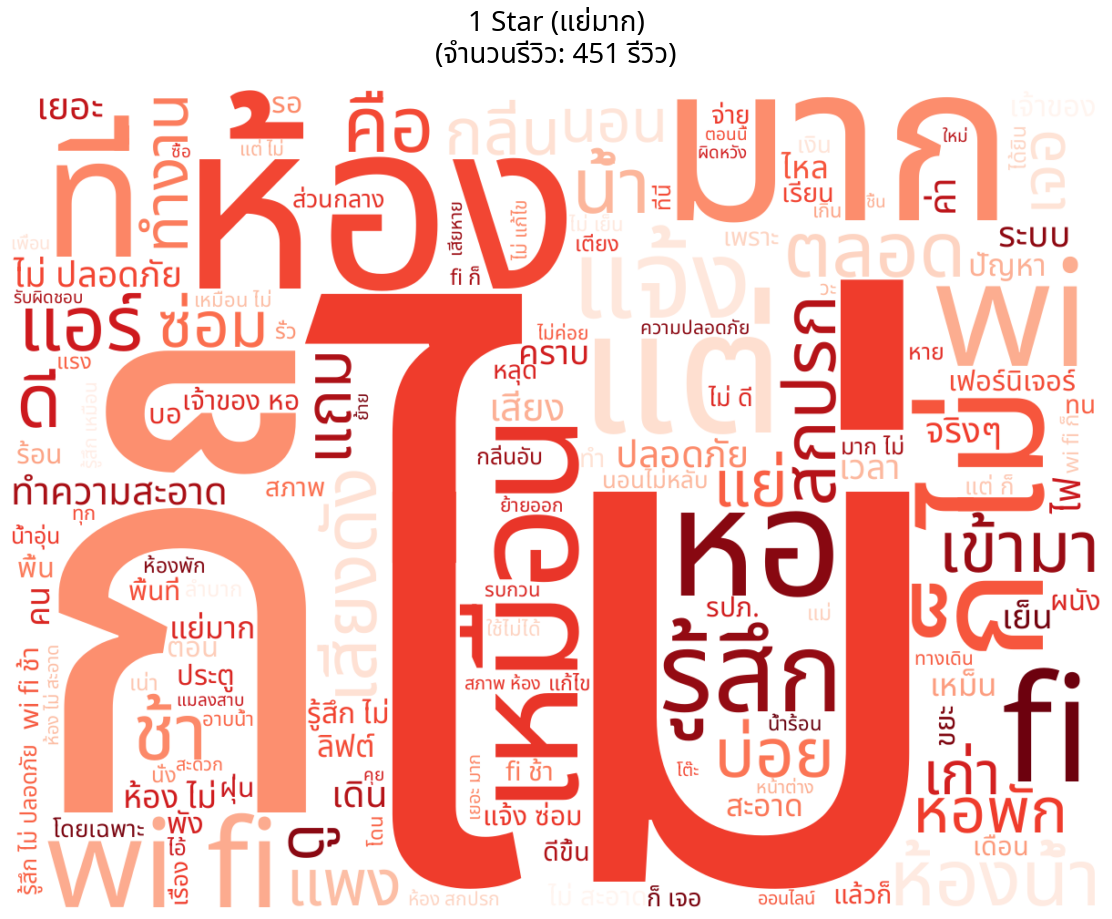

บันทึก N-gram Word Cloud สำหรับ 1.0 ดาวแล้วที่: C:\Users\Phutawan Chonsakorn\Downloads\Roomaroo_TextClassification\images\wordclouds\ngram_word_cloud_1.0_star.png


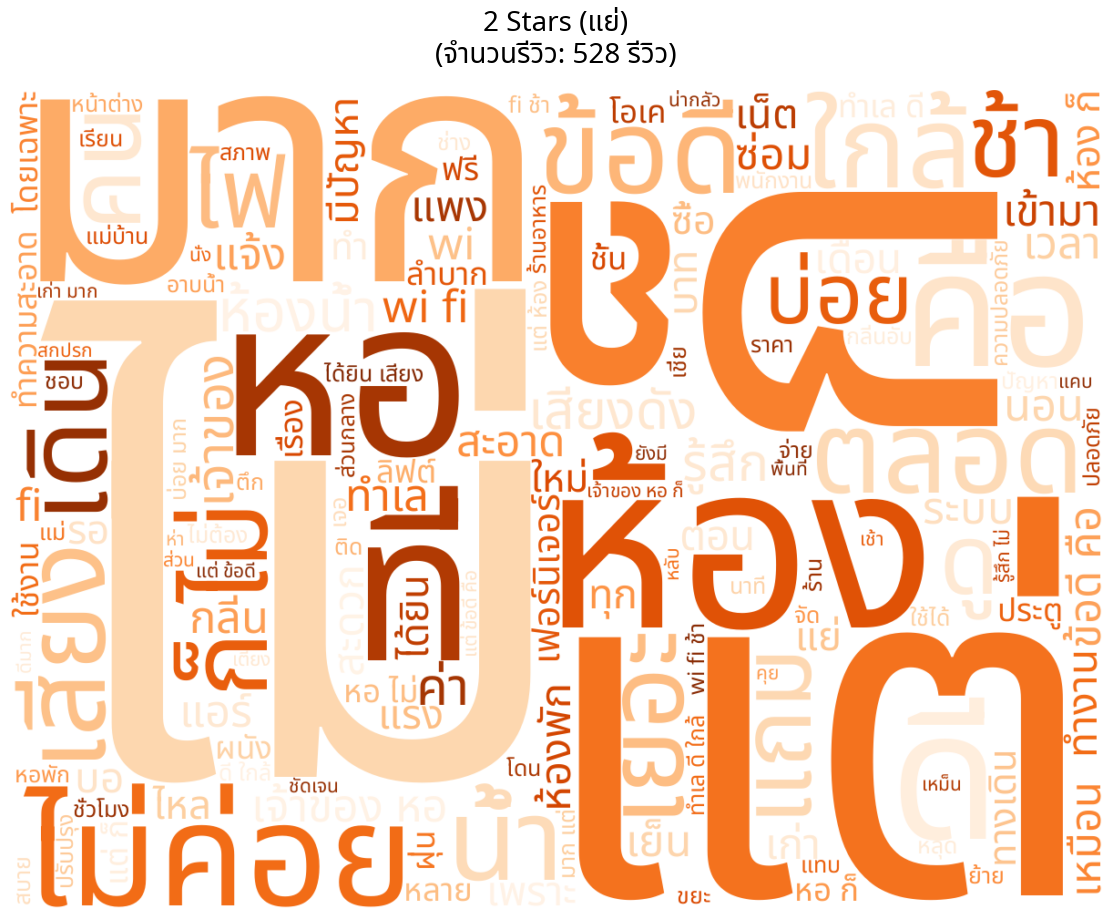

บันทึก N-gram Word Cloud สำหรับ 2.0 ดาวแล้วที่: C:\Users\Phutawan Chonsakorn\Downloads\Roomaroo_TextClassification\images\wordclouds\ngram_word_cloud_2.0_star.png


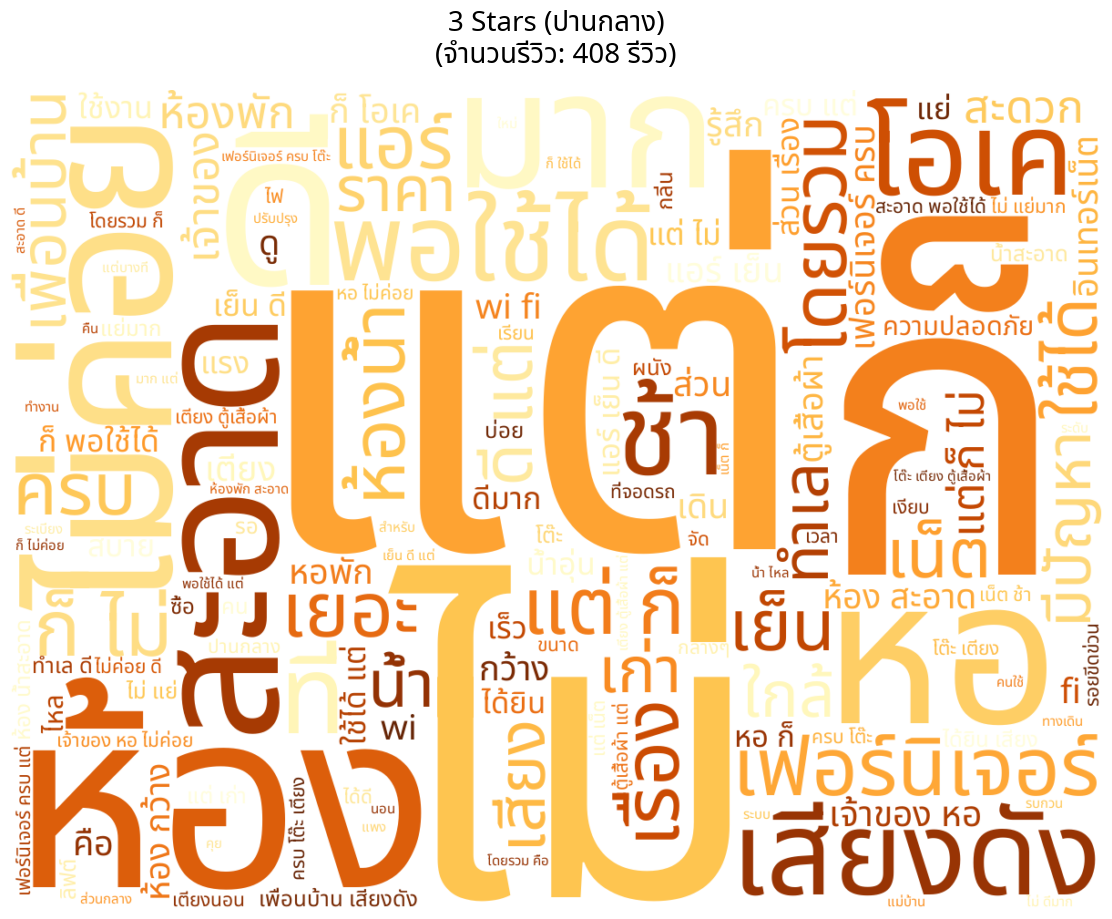

บันทึก N-gram Word Cloud สำหรับ 3.0 ดาวแล้วที่: C:\Users\Phutawan Chonsakorn\Downloads\Roomaroo_TextClassification\images\wordclouds\ngram_word_cloud_3.0_star.png


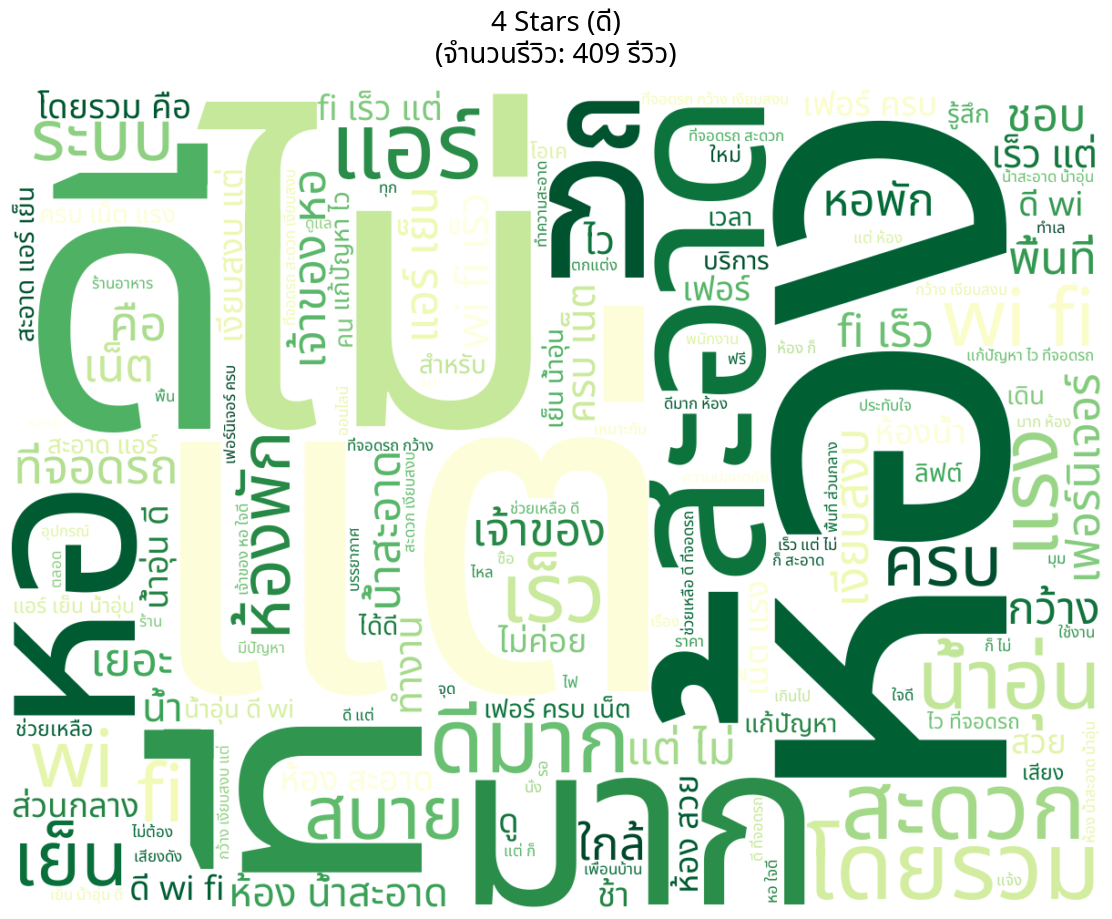

บันทึก N-gram Word Cloud สำหรับ 4.0 ดาวแล้วที่: C:\Users\Phutawan Chonsakorn\Downloads\Roomaroo_TextClassification\images\wordclouds\ngram_word_cloud_4.0_star.png


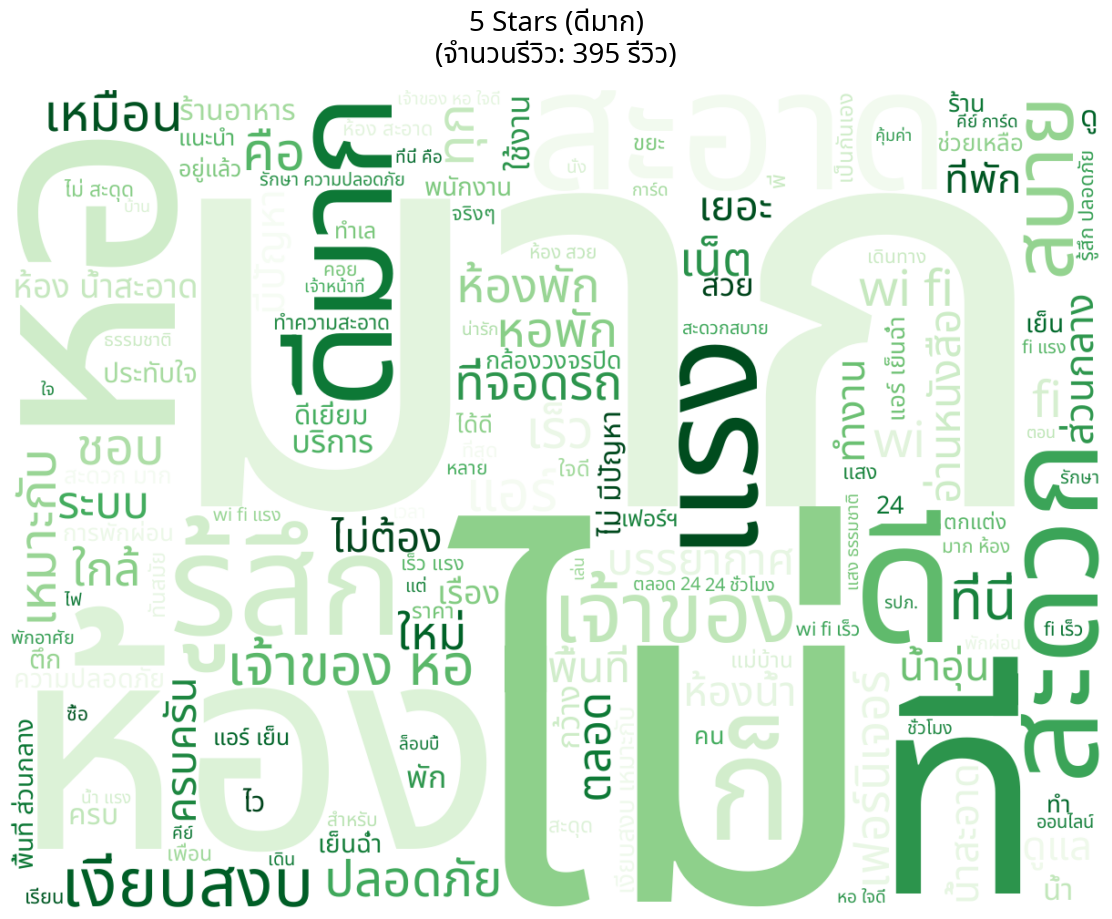

บันทึก N-gram Word Cloud สำหรับ 5.0 ดาวแล้วที่: C:\Users\Phutawan Chonsakorn\Downloads\Roomaroo_TextClassification\images\wordclouds\ngram_word_cloud_5.0_star.png

คำและวลีที่พบบ่อยที่สุด 15 อันดับแรกของแต่ละระดับคะแนน

⭐ 1 Star (แย่มาก)


,อันดับ,คำ,ความถี่
0,1,ไม่,732
1,2,ก็,392
2,3,ห้อง,286
3,4,มาก,249
4,5,แต่,138
5,6,ที่,131
6,7,ก็ ไม่,112
7,8,หอ,107
8,9,เหมือน,105
9,10,wi,104




⭐ 2 Stars (แย่)


,อันดับ,คำ,ความถี่
0,1,ไม่,692
1,2,ก็,576
2,3,แต่,451
3,4,มาก,396
4,5,ห้อง,387
5,6,หอ,347
6,7,ที่,301
7,8,ดี,224
8,9,คือ,177
9,10,ไม่ค่อย,166




⭐ 3 Stars (ปานกลาง)


,อันดับ,คำ,ความถี่
0,1,แต่,591
1,2,ก็,471
2,3,ไม่,424
3,4,ห้อง,295
4,5,ดี,217
5,6,หอ,189
6,7,ไม่ค่อย,154
7,8,สะอาด,134
8,9,มาก,120
9,10,เสียงดัง,102




⭐ 4 Stars (ดี)


,อันดับ,คำ,ความถี่
0,1,แต่,392
1,2,ห้อง,336
2,3,ไม่,290
3,4,ดี,246
4,5,ที่,199
5,6,มาก,171
6,7,หอ,162
7,8,ก็,145
8,9,สะอาด,129
9,10,โดยรวม,113




⭐ 5 Stars (ดีมาก)


,อันดับ,คำ,ความถี่
0,1,มาก,204
1,2,ไม่,201
2,3,ห้อง,188
3,4,หอ,180
4,5,ที่,176
5,6,สะอาด,113
6,7,ดี,111
7,8,ก็,82
8,9,รู้สึก,78
9,10,ดีมาก,77


In [89]:
# --- สร้างและบันทึก Word Cloud แยกไฟล์ (โดยใช้ N-grams) ---
all_words_by_rating = {}
top_words_by_rating = {}

print("กำลังสร้างและบันทึก Word Cloud แยกตามระดับคะแนน...")

for rating in sorted(df['rating'].unique()):
    rating_texts = df[df['rating'] == rating]['cleaned_review'].tolist()
    combined_text = ' '.join(rating_texts)
    
    # 1. ตัดคำ (Tokenize) เพื่อให้ได้คำเดี่ยว (Unigrams)
    words = word_tokenize(combined_text, engine='newmm')
    words = [word.strip() for word in words if len(word.strip()) > 1]
    
    # 2. สร้าง Bigrams และ Trigrams
    bigrams = [' '.join(gram) for gram in ngrams(words, 2)]
    trigrams = [' '.join(gram) for gram in ngrams(words, 3)]
    
    # 3. รวม tokens ทั้งหมด (Unigrams + Bigrams + Trigrams)
    all_tokens = words + bigrams + trigrams
    
    # 4. นับความถี่จาก tokens ทั้งหมด
    word_freq = Counter(all_tokens)
    all_words_by_rating[rating] = word_freq
    top_words_by_rating[rating] = word_freq.most_common(15)
    
    if len(word_freq) > 0:
        wordcloud = WordCloud(
            font_path=THAI_FONT_PATH,
            width=1200, height=900, background_color='white',
            colormap=rating_colors[rating],
            max_words=150,
            # เพิ่ม collocations=False เพื่อให้ WordCloud ไม่พยายามสร้างกลุ่มคำเองซ้ำซ้อน
            collocations=False, 
            relative_scaling=0.5, min_font_size=10
        ).generate_from_frequencies(word_freq)
        
        plt.figure(figsize=(12, 9))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'{rating_names[rating]}\n(จำนวนรีวิว: {len(rating_texts)} รีวิว)', 
                  fontsize=20, fontweight='bold', pad=20)
        plt.axis('off')
        plt.tight_layout(pad=0)
        
        filename = f"ngram_word_cloud_{rating}_star.png"
        save_path = os.path.join(wordcloud_output_dir, filename)
        
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
        print(f"บันทึก N-gram Word Cloud สำหรับ {rating} ดาวแล้วที่: {save_path}")
    else:
        print(f"ไม่มีข้อมูลสำหรับสร้าง Word Cloud ของเรตติ้ง {rating} ดาว")

print("\nคำและวลีที่พบบ่อยที่สุด 15 อันดับแรกของแต่ละระดับคะแนน")
for rating in sorted(df['rating'].unique()):
    print(f"\n⭐ {rating_names[rating]}")
    print(f"{'='*80}")
    
    # สร้างตารางแสดงผล
    top_words_df = pd.DataFrame(
        top_words_by_rating[rating],
        columns=['คำ', 'ความถี่']
    )
    top_words_df.insert(0, 'อันดับ', range(1, len(top_words_df) + 1))
    
    # แสดงผลเป็นตารางสวยงามใน Notebook
    display(top_words_df)
    print()

In [90]:
# --- วิเคราะห์และแสดงผลคำที่ปรากฏในทุก rating ---
print(f"\n{'='*100}")
print("🔍 การวิเคราะห์คำที่ปรากฏในทุกระดับคะแนน")
print(f"{'='*100}\n")

# หาคำที่ปรากฏในทุก rating
common_words = set(all_words_by_rating[1].keys())
for rating in range(2, 6):
    if rating in all_words_by_rating:
        common_words = common_words.intersection(set(all_words_by_rating[rating].keys()))

# นับความถี่รวมของคำที่ปรากฏในทุก rating
common_word_freq = Counter()
for word in common_words:
    total_freq = sum(all_words_by_rating[rating][word] for rating in all_words_by_rating.keys())
    common_word_freq[word] = total_freq

# สร้าง DataFrame จาก common_words ทั้งหมด
all_common_df = pd.DataFrame(common_word_freq.items(), columns=['คำ', 'ความถี่รวม'])
# จัดเรียงข้อมูลตามความถี่รวมจากมากไปน้อย
all_common_df = all_common_df.sort_values(by='ความถี่รวม', ascending=False).reset_index(drop=True)
# เพิ่มคอลัมน์ 'อันดับ'
all_common_df.insert(0, 'อันดับ', range(1, len(all_common_df) + 1))

# แสดงผลตารางของคำที่ปรากฏในทุกระดับคะแนนทั้งหมด
print(f"📋 ตารางแสดงคำที่พบบ่อยในทุกระดับคะแนนทั้งหมด ({len(all_common_df)} คำ):")
# แสดงผลเป็นตารางสวยงามใน Notebook
display(all_common_df)


🔍 การวิเคราะห์คำที่ปรากฏในทุกระดับคะแนน

📋 ตารางแสดงคำที่พบบ่อยในทุกระดับคะแนนทั้งหมด (541 คำ):


,อันดับ,คำ,ความถี่รวม
0,1,ไม่,2339
1,2,ก็,1666
2,3,แต่,1588
3,4,ห้อง,1492
4,5,มาก,1140
...,...,...,...
536,537,ใกล้ แหล่ง,6
537,538,โคมไฟ,6
538,539,หัว เตียง,6
539,540,ก็ แรง,5


In [91]:
# เพิ่มโค้ดนี้หลังจาก Section 5 (Data Cleaning)
print("\n" + "="*100)
print("ตัวอย่างข้อมูลก่อนและหลังการทำความสะอาด (Text Preprocessing)")
print("="*100)

# แสดง 5 ตัวอย่างแรก
sample_df = df.head(10).copy()
comparison_df = pd.DataFrame({
    'Rating': sample_df['rating'],
    'ข้อความเดิม': sample_df['text'].str[:80] + '...',
    'ข้อความหลัง Cleaning': sample_df['cleaned_review'].str[:80] + '...',
    'จำนวนคำ': sample_df['word_count']
})

display(comparison_df)


ตัวอย่างข้อมูลก่อนและหลังการทำความสะอาด (Text Preprocessing)


,Rating,ข้อความเดิม,ข้อความหลัง Cleaning,จำนวนคำ
0,5.0,อยู่ที่นี่มาจะครบปีแล้วค่ะ ประทับใจมาก หอเงียบ...,ที่นี่ ครบ ปี ประทับใจ มาก หอ เงียบสงบ ส...,71
1,5.0,หอคือดีมากแบบ 10/10 ไม่หัก ห้องเหมือนในรูปไม่จ...,หอ คือ ดีมาก 10 10 ไม่ หัก ห้อง เหมือน...,49
2,5.0,แอร์เย็นน้ำแรง ไม่มีอะไรให้บ่นเลยจริงๆ อยู่มาจ...,แอร์ เย็น น้ำ แรง ไม่ บ่น จริงๆ 3 เทอม...,29
3,5.0,ชอบตรงที่มี working space ใหญ่ๆ ด้านล่าง นั่งท...,ชอบ ที่ working space ด้านล่าง นั่ง ...,33
4,5.0,ห้องสะอาดทุกมุม แม่บ้านมาทุกอาทิตย์ เจ้าของหอพ...,ห้อง สะอาด ทุก มุม แม่บ้าน ทุก อาทิตย์ เจ้...,57
5,5.0,อยู่มาเกือบสองปีแล้ว ไม่เคยมีปัญหาอะไรเลย น้ำไ...,สอง ปี ไม่ มีปัญหา น้ำ ไม่ ไฟ ไม่ ดับ ...,31
6,5.0,ระบบความปลอดภัยดีมาก กล้องวงจรปิดชัดเวอร์ ตอนข...,ระบบ ความปลอดภัย ดีมาก กล้องวงจรปิด ชัด เวอร...,23
7,5.0,หอนี้มีฟิตเนสขนาดเล็กให้ใช้ฟรีด้วยนะ เอาไว้เล่...,หอ ฟิตเนส ขนาดเล็ก ฟรี เอาไว้ เล่น เบา นอน...,29
8,5.0,ที่นี่เหมาะกับคนที่ชอบความสงบ ไม่วุ่นวาย ห้องม...,ที่นี่ เหมาะกับ คน ที่ ชอบ ความสงบ ไม่ วุ่นว...,39
9,5.0,แนะนำสำหรับนักศึกษาที่ไม่อยากเหนื่อยเรื่องหอ เ...,แนะนำ สำหรับ นักศึกษา ที่ ไม่ เหนื่อย เรื่อง ห...,39


## **6. Split Data**


In [92]:
# แบ่งข้อมูลเป็น train และ test set (80/20) โดย stratify ตาม rating
X_train, X_test, y_train, y_test = train_test_split(
    df[feature_columns],
    df['rating'],
    test_size=0.2,
    random_state=42,
    stratify=df['rating']
)

# พิมพ์จำนวนข้อมูล train และ test
print(f"จำนวนข้อมูลฝึกฝน: {len(X_train)}")
print(f"จำนวนข้อมูลทดสอบ: {len(X_test)}")

จำนวนข้อมูลฝึกฝน: 1752
จำนวนข้อมูลทดสอบ: 439


In [93]:
# เรียงลำดับ rating ที่ unique
rating_order = sorted(df['rating'].unique())
# นับจำนวนใน train set
train_counts = y_train.value_counts().reindex(rating_order, fill_value=0).tolist()
# นับจำนวนใน test set
test_counts = y_test.value_counts().reindex(rating_order, fill_value=0).tolist()
# คำนวณรวม
total_counts = [train + test for train, test in zip(train_counts, test_counts)]

# สร้าง DataFrame สำหรับตาราง
table_data = {
    'คะแนน': rating_order,
    'ชุดฝึก (รีวิว)': train_counts,
    'ชุดทดสอบ (รีวิว)': test_counts,
    'รวม (รีวิว)': total_counts
}
table = pd.DataFrame(table_data)

# เพิ่มแถวรวม
table.loc['รวม'] = ['รวม', sum(train_counts), sum(test_counts), sum(total_counts)]

# พิมพ์ตารางการกระจายคะแนน
print("\nการกระจายคะแนนรีวิวในชุดข้อมูลฝึกและทดสอบ")
print(table.to_string(index=False))


การกระจายคะแนนรีวิวในชุดข้อมูลฝึกและทดสอบ
คะแนน  ชุดฝึก (รีวิว)  ชุดทดสอบ (รีวิว)  รวม (รีวิว)
  1.0             361                90          451
  2.0             422               106          528
  3.0             326                82          408
  4.0             327                82          409
  5.0             316                79          395
  รวม            1752               439         2191


## **7. Create Feature Vectors**


In [94]:
# กำหนด tokenizer แบบกำหนดเองโดยใช้ word_tokenize
from utils import custom_tokenizer

# สร้างเวกเตอร์ Thai2fit สำหรับ train set
X_train_vectors = np.array([enhanced_sentence_vectorizer(text) for text in X_train['cleaned_review']])
# สร้างเวกเตอร์ Thai2fit สำหรับ test set
X_test_vectors = np.array([enhanced_sentence_vectorizer(text) for text in X_test['cleaned_review']])

# สร้าง TF-IDF vectorizer ด้วยพารามิเตอร์ที่กำหนด
tfidf_vectorizer = TfidfVectorizer( 
    tokenizer=custom_tokenizer,
    max_features=10000,
    ngram_range=(1, 3),
    min_df=2, max_df=0.85,
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True
)

# สร้าง CountVectorizer ด้วยพารามิเตอร์ที่กำหนด
count_vectorizer = CountVectorizer(
    tokenizer=custom_tokenizer,
    max_features=3000,
    ngram_range=(1, 2),
    min_df=3, max_df=0.85
)

# Fit และ transform TF-IDF บน train set
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['cleaned_review'])
# Transform TF-IDF บน test set
X_test_tfidf = tfidf_vectorizer.transform(X_test['cleaned_review'])

# Fit และ transform CountVectorizer บน train set
X_train_count = count_vectorizer.fit_transform(X_train['cleaned_review'])
# Transform CountVectorizer บน test set
X_test_count = count_vectorizer.transform(X_test['cleaned_review'])

# แปลงเวกเตอร์ Thai2fit เป็น sparse matrix
X_train_vectors_sparse = csr_matrix(X_train_vectors)
X_test_vectors_sparse = csr_matrix(X_test_vectors)

# สร้าง scaler สำหรับเวกเตอร์ (with_mean=False สำหรับ sparse)
scaler = StandardScaler(with_mean=False)
# Fit และ transform scaler บน train vectors
X_train_vectors_scaled = scaler.fit_transform(X_train_vectors_sparse)
# Transform scaler บน test vectors
X_test_vectors_scaled = scaler.transform(X_test_vectors_sparse)

# เลือกคอลัมน์ numerical features
numerical_features = [col for col in feature_columns if col != 'cleaned_review']
# แปลงเป็น array สำหรับ train
X_train_additional = X_train[numerical_features].values
# แปลงเป็น array สำหรับ test
X_test_additional = X_test[numerical_features].values

# สร้าง scaler สำหรับ features เพิ่มเติม
features_scaler = StandardScaler()
# Fit และ transform บน train additional
X_train_additional_scaled = features_scaler.fit_transform(X_train_additional)
# Transform บน test additional
X_test_additional_scaled = features_scaler.transform(X_test_additional)

c:\Users\Phutawan Chonsakorn\Downloads\Roomaroo_TextClassification\venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [95]:
# พิมพ์จำนวน features แต่ละประเภท
print(f"TF-IDF features: {X_train_tfidf.shape[1]}")
print(f"Count features: {X_train_count.shape[1]}")
print(f"Thai2fit features: {X_train_vectors.shape[1]}")
print(f"Additional features: {X_train_additional.shape[1]}")
print(f"Total features: {X_train_tfidf.shape[1] + X_train_count.shape[1] + X_train_vectors.shape[1] + X_train_additional.shape[1]}")

TF-IDF features: 10000
Count features: 3000
Thai2fit features: 300
Additional features: 12
Total features: 13312


## **8. Combine All Features**


In [96]:
# รวม features ทั้งหมดสำหรับ train set โดยใช้ hstack
X_train_combined = hstack([
    X_train_tfidf,         # TF-IDF features
    X_train_count,         # Count vectors
    X_train_vectors_scaled, # Thai2fit embeddings
    csr_matrix(X_train_additional_scaled) # คุณลักษณะเพิ่มเติม
])

# รวม features ทั้งหมดสำหรับ test set โดยใช้ hstack
X_test_combined = hstack([
    X_test_tfidf,
    X_test_count,
    X_test_vectors_scaled,
    csr_matrix(X_test_additional_scaled)
])

# สร้าง features สำหรับ MultinomialNB (ใช้เฉพาะ TF-IDF และ Count vectors ที่เป็นค่าบวก)
X_train_nb = hstack([X_train_tfidf, X_train_count])
X_test_nb = hstack([X_test_tfidf, X_test_count])

print(f"ขนาดของ features สำหรับ MultinomialNB - train: {X_train_nb.shape}, test: {X_test_nb.shape}")

# พิมพ์ขนาดของ features รวม
print(f"ขนาดของ features รวม - train: {X_train_combined.shape}, test: {X_test_combined.shape}")

ขนาดของ features สำหรับ MultinomialNB - train: (1752, 13000), test: (439, 13000)
ขนาดของ features รวม - train: (1752, 13312), test: (439, 13312)


## **9. Train Model**


In [97]:
# กำหนด dictionary ของโมเดลต่างๆ ด้วยพารามิเตอร์ที่ปรับแต่ง
models = {
    'Logistic Regression': LogisticRegression(
        C=0.15,                     # ค่า regularization parameter (0.15 ทำให้โมเดลมีความทั่วไปมากขึ้น)
        class_weight='balanced',    # ช่วยจัดการกับข้อมูลที่ไม่สมดุล
        penalty='l2',               # L2 regularization ช่วยป้องกัน overfitting
        solver='saga',              # อัลกอริทึมที่มีประสิทธิภาพดีสำหรับข้อมูลขนาดใหญ่
        tol=0.0001,                 # เกณฑ์การหยุด
        max_iter=1000,              # เพิ่มจำนวนรอบการฝึก
        random_state=42,            # กำหนดค่า random seed
        multi_class='multinomial',  # เป็นโมเดลจำแนกหลายคลาส (multiclass)
        n_jobs=-1                   # ใช้ทุก CPU cores
    ),
    'Multinomial Naive Bayes': MultinomialNB(
        alpha=0.1,  # Smoothing parameter เพื่อป้องกัน zero probability
        fit_prior=True  # เรียนรู้ prior probabilities จากข้อมูล
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,  # จำนวนต้นไม้ใน forest
        max_depth=10,  # ความลึกสูงสุดของต้นไม้เพื่อป้องกัน overfitting
        min_samples_split=5,  # จำนวนตัวอย่างขั้นต่ำในการแยกโหนด
        min_samples_leaf=2,  # จำนวนตัวอย่างขั้นต่ำใน leaf node
        random_state=42,  # กำหนด random seed
        n_jobs=-1  # ใช้ทุก CPU cores
    )
}



## **10. Evaluate Model**



กำลังฝึก Logistic Regression...


c:\Users\Phutawan Chonsakorn\Downloads\Roomaroo_TextClassification\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression
เวลาในการฝึก: 23.88 วินาที
Model Accuracy: 0.7722
Features ที่ใช้: 13312 features

Classification Report:
              precision    recall  f1-score   support

         1.0       0.77      0.91      0.84        90
         2.0       0.82      0.77      0.80       106
         3.0       0.78      0.73      0.75        82
         4.0       0.74      0.61      0.67        82
         5.0       0.74      0.82      0.78        79

    accuracy                           0.77       439
   macro avg       0.77      0.77      0.77       439
weighted avg       0.77      0.77      0.77       439



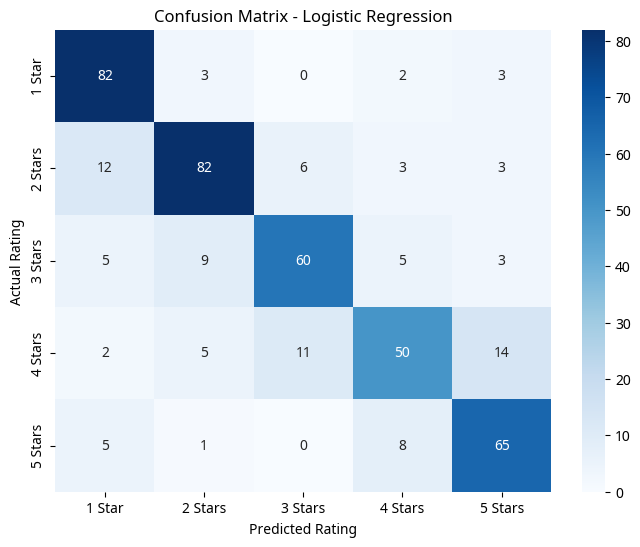


กำลังฝึก Multinomial Naive Bayes...

Multinomial Naive Bayes
เวลาในการฝึก: 0.03 วินาที
Model Accuracy: 0.7654
Features ที่ใช้: 13000 features

Classification Report:
              precision    recall  f1-score   support

         1.0       0.81      0.84      0.83        90
         2.0       0.72      0.79      0.76       106
         3.0       0.74      0.78      0.76        82
         4.0       0.69      0.61      0.65        82
         5.0       0.87      0.78      0.83        79

    accuracy                           0.77       439
   macro avg       0.77      0.76      0.76       439
weighted avg       0.77      0.77      0.76       439



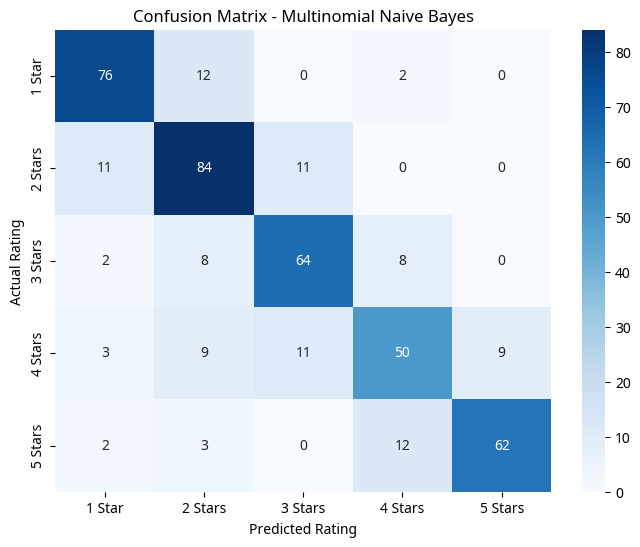


กำลังฝึก Random Forest...

Random Forest
เวลาในการฝึก: 0.61 วินาที
Model Accuracy: 0.7198
Features ที่ใช้: 13312 features

Classification Report:
              precision    recall  f1-score   support

         1.0       0.70      0.89      0.78        90
         2.0       0.76      0.70      0.73       106
         3.0       0.73      0.70      0.71        82
         4.0       0.83      0.52      0.64        82
         5.0       0.65      0.78      0.71        79

    accuracy                           0.72       439
   macro avg       0.73      0.72      0.71       439
weighted avg       0.73      0.72      0.72       439



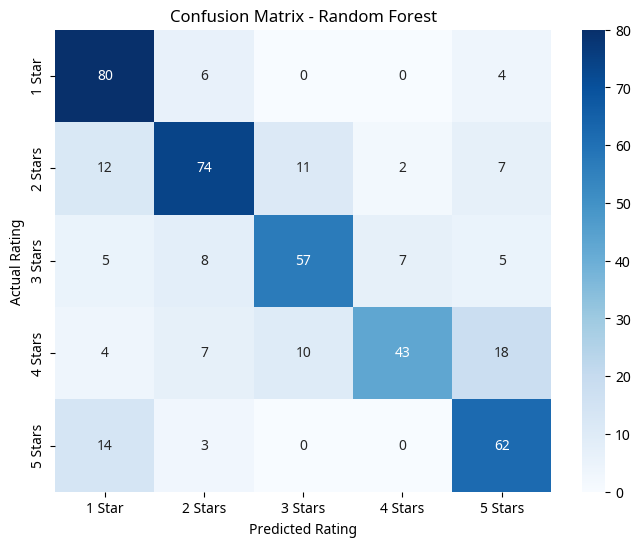

In [98]:
# สร้าง dictionary สำหรับเก็บผลลัพธ์ของแต่ละโมเดล
results = {}

# ลูปผ่านแต่ละโมเดล
for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"กำลังฝึก {name}...")
    print(f"{'='*60}")
    
    # เริ่มจับเวลา training
    start_time = time.time()
    
    # เลือก features ตามประเภทโมเดล
    if name == 'Multinomial Naive Bayes':
        # ใช้เฉพาะ TF-IDF และ Count vectors สำหรับ MultinomialNB
        X_train_model = X_train_nb
        X_test_model = X_test_nb
    else:
        # ใช้ features ครบสำหรับโมเดลอื่น
        X_train_model = X_train_combined
        X_test_model = X_test_combined
    
    # ฝึกโมเดลด้วย train set
    model.fit(X_train_model, y_train)
    
    # คำนวณเวลาที่ใช้ training
    training_time = time.time() - start_time
    
    # ทำนายบน test set
    y_pred = model.predict(X_test_model)
    
    # คำนวณ accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # เก็บผลลัพธ์ใน dictionary
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'training_time': training_time,
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'X_train': X_train_model,  # เก็บ features ที่ใช้ฝึก
        'X_test': X_test_model     # เก็บ features ที่ใช้ทดสอบ
    }
    
    # แสดงผลลัพธ์ของโมเดลนี้
    print(f"\n{name}")
    print(f"เวลาในการฝึก: {training_time:.2f} วินาที")
    print(f"Model Accuracy: {accuracy:.4f}")
    print(f"Features ที่ใช้: {X_train_model.shape[1]} features")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # สร้างพล็อต confusion matrix (ใช้ตัวเลขแทน emoji เพื่อแก้ปัญหา font)
    plt.figure(figsize=(8, 6))
    sns.heatmap(results[name]['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars'],
                yticklabels=['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars'])
    plt.xlabel("Predicted Rating")
    plt.ylabel("Actual Rating")
    plt.title(f"Confusion Matrix - {name}")
    
    filename = f"{name.replace(' ', '_')}_confusion_matrix.png"
    save_path = os.path.join(model_output_dir, filename)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()



In [99]:
# สรุปผลการเปรียบเทียบโมเดลทั้งหมด
print(f"\n{'='*80}")
print("📈 สรุปผลการเปรียบเทียบโมเดลทั้งหมด")
print(f"{'='*80}")

comparison_data = []
for name, result in results.items():
    comparison_data.append({
        'โมเดล': name,
        'ความแม่นยำ': f"{result['accuracy']:.4f}",
        'เวลาฝึก (วินาที)': f"{result['training_time']:.2f}",
        'จำนวน Features': result['X_train'].shape[1],
        'Macro Avg F1': f"{result['classification_report']['macro avg']['f1-score']:.4f}",
        'Weighted Avg F1': f"{result['classification_report']['weighted avg']['f1-score']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# หาโมเดลที่ดีที่สุด
best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
print(f"\n🏆 โมเดลที่ดีที่สุด: {best_model_name} (Accuracy: {results[best_model_name]['accuracy']:.4f})")

# เก็บโมเดลที่ดีที่สุดไว้ใช้งาน
best_model = results[best_model_name]['model']


📈 สรุปผลการเปรียบเทียบโมเดลทั้งหมด
                  โมเดล ความแม่นยำ เวลาฝึก (วินาที)  จำนวน Features Macro Avg F1 Weighted Avg F1
    Logistic Regression     0.7722            23.88           13312       0.7665          0.7694
Multinomial Naive Bayes     0.7654             0.03           13000       0.7642          0.7645
          Random Forest     0.7198             0.61           13312       0.7138          0.7157

🏆 โมเดลที่ดีที่สุด: Logistic Regression (Accuracy: 0.7722)


## **10.5 Analyze Misclassification Patterns**

In [100]:
## **10.5 วิเคราะห์รูปแบบการทำนายแบบยืดหยุ่น (เวอร์ชันย่อ)**

from collections import Counter
import pandas as pd

def analyze_specific_group(actual_rating, predicted_rating, y_true, y_pred, X_data):
    """
    วิเคราะห์กลุ่มเฉพาะและคืนค่าความถี่คำ
    """
    
    # สร้าง DataFrame สำหรับวิเคราะห์
    analysis_df = pd.DataFrame({
        'คะแนนจริง': y_true.values,
        'คะแนนทำนาย': y_pred,
        'รีวิว': X_data['cleaned_review'].values
    })
    
    # กรองข้อมูลตามเงื่อนไข
    target_data = analysis_df[
        (analysis_df['คะแนนจริง'] == actual_rating) & 
        (analysis_df['คะแนนทำนาย'] == predicted_rating)
    ]
    
    if len(target_data) == 0:
        return None, 0
    
    # รวบรวมคำทั้งหมดและนับความถี่
    all_words = []
    for review in target_data['รีวิว']:
        words = word_tokenize(review, engine='newmm')
        all_words.extend([w for w in words if len(w.strip()) > 1])
    
    word_freq = Counter(all_words)
    
    return word_freq, len(target_data)


def compare_common_words(actual_A, predicted_A, actual_B, predicted_B, 
                         y_true, y_pred, X_data, top_n=30):
    """
    เปรียบเทียบคำที่ปรากฏในทั้ง 2 กลุ่ม
    """
    
    print(f"\n{'#'*100}")
    print(f"การเปรียบเทียบคำที่ใช้ในทั้ง 2 กลุ่ม")
    print(f"{'#'*100}")
    
    # วิเคราะห์กลุ่ม A
    freq_A, count_A = analyze_specific_group(
        actual_A, predicted_A, y_true, y_pred, X_data
    )
    
    if freq_A is None:
        print(f"\nไม่พบข้อมูลในกลุ่ม A (คะแนนจริง {actual_A} -> ทำนาย {predicted_A})")
        return
    
    # วิเคราะห์กลุ่ม B
    freq_B, count_B = analyze_specific_group(
        actual_B, predicted_B, y_true, y_pred, X_data
    )
    
    if freq_B is None:
        print(f"\nไม่พบข้อมูลในกลุ่ม B (คะแนนจริง {actual_B} -> ทำนาย {predicted_B})")
        return
    
    # สร้างชื่อกลุ่ม
    group_A_name = f"จริง {actual_A}->ทำนาย {predicted_A}"
    group_B_name = f"จริง {actual_B}->ทำนาย {predicted_B}"
    status_A = "ถูกต้อง" if actual_A == predicted_A else "ผิดพลาด"
    status_B = "ถูกต้อง" if actual_B == predicted_B else "ผิดพลาด"
    
    print(f"\nกลุ่ม A: {group_A_name} ({status_A}) - {count_A} รีวิว")
    print(f"กลุ่ม B: {group_B_name} ({status_B}) - {count_B} รีวิว")
    
    # หาคำที่ปรากฏในทั้ง 2 กลุ่ม
    common_words = set(freq_A.keys()) & set(freq_B.keys())
    
    if not common_words:
        print("\nไม่พบคำที่ปรากฏในทั้ง 2 กลุ่ม")
        return
    
    # สร้างตารางเปรียบเทียบ
    comparison_data = []
    
    for word in common_words:
        freq_a = freq_A[word]
        freq_b = freq_B[word]
        ratio_a_b = freq_a / freq_b if freq_b > 0 else float('inf')
        ratio_b_a = freq_b / freq_a if freq_a > 0 else float('inf')
        
        comparison_data.append({
            'คำ': word,
            f'ความถี่ใน A': freq_a,
            f'ความถี่ใน B': freq_b,
            'อัตราส่วน A/B': round(ratio_a_b, 2),
            'อัตราส่วน B/A': round(ratio_b_a, 2),
            'ผลรวมความถี่': freq_a + freq_b
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # เรียงตามผลรวมความถี่ (คำที่ปรากฏบ่อยที่สุด)
    comparison_df = comparison_df.sort_values('ผลรวมความถี่', ascending=False)
    comparison_df = comparison_df.head(top_n)
    comparison_df.insert(0, 'อันดับ', range(1, len(comparison_df) + 1))
    
    print(f"\n{'='*120}")
    print(f"ตารางเปรียบเทียบคำที่ปรากฏในทั้ง 2 กลุ่ม (Top {top_n})")
    print(f"{'='*120}")
    print(f"หมายเหตุ:")
    print(f"  - กลุ่ม A: {group_A_name}")
    print(f"  - กลุ่ม B: {group_B_name}")
    print(f"  - อัตราส่วน A/B > 1 หมายถึง คำนั้นปรากฏในกลุ่ม A มากกว่า")
    print(f"  - อัตราส่วน B/A > 1 หมายถึง คำนั้นปรากฏในกลุ่ม B มากกว่า")
    print(f"{'='*120}\n")
    
    # ลบคอลัมน์ที่ไม่จำเป็นออกจากการแสดงผล
    display_df = comparison_df.drop('ผลรวมความถี่', axis=1)
    print(display_df.to_string(index=False))
    
    # แสดงสรุปเพิ่มเติม
    print(f"\n{'='*120}")
    print(f"สรุป:")
    print(f"  - จำนวนคำที่ปรากฏในทั้ง 2 กลุ่ม: {len(common_words)} คำ")
    print(f"  - แสดงผล: {len(display_df)} คำ")
    
    # หาคำที่แตกต่างกันมากที่สุด
    max_diff_A = comparison_df.nlargest(3, 'อัตราส่วน A/B')[['คำ', 'อัตราส่วน A/B']]
    max_diff_B = comparison_df.nlargest(3, 'อัตราส่วน B/A')[['คำ', 'อัตราส่วน B/A']]
    
    print(f"\n  คำที่โดดเด่นในกลุ่ม A (อัตราส่วน A/B สูงสุด):")
    for idx, row in max_diff_A.iterrows():
        print(f"    - {row['คำ']} (อัตราส่วน: {row['อัตราส่วน A/B']})")
    
    print(f"\n  คำที่โดดเด่นในกลุ่ม B (อัตราส่วน B/A สูงสุด):")
    for idx, row in max_diff_B.iterrows():
        print(f"    - {row['คำ']} (อัตราส่วน: {row['อัตราส่วน B/A']})")
    
    print(f"{'='*120}")


def interactive_comparison(y_true, y_pred, X_data):
    """
    ฟังก์ชันหลักสำหรับการเปรียบเทียบแบบ Interactive
    หมายเหตุ: กด Ctrl+C หรือพิมพ์ 'q' เพื่อยกเลิกการทำงาน
    """
    
    print("\nหมายเหตุ: พิมพ์ 'q' หรือกด Ctrl+C เพื่อยกเลิกการทำงานได้ทุกเมื่อ")
    
    while True:
        print("\n" + "="*100)
        print("เลือกกลุ่มที่ต้องการเปรียบเทียบ")
        print("="*100)
        
        try:
            # รับข้อมูลกลุ่ม A
            print("\n--- กลุ่ม A ---")
            actual_A_input = input("กรุณากรอกคะแนนจริง (กลุ่ม A) [1-5] หรือ 'q' เพื่อยกเลิก: ").strip()
            
            # ตรวจสอบการยกเลิก
            if actual_A_input.lower() == 'q' or actual_A_input == '':
                print("\nยกเลิกการทำงาน")
                break
            
            actual_A = int(actual_A_input)
            if actual_A < 1 or actual_A > 5:
                print("คะแนนต้องอยู่ระหว่าง 1-5 เท่านั้น")
                continue
            
            predicted_A_input = input("กรุณากรอกคะแนนทำนาย (กลุ่ม A) [1-5] หรือ 'q' เพื่อยกเลิก: ").strip()
            
            # ตรวจสอบการยกเลิก
            if predicted_A_input.lower() == 'q' or predicted_A_input == '':
                print("\nยกเลิกการทำงาน")
                break
            
            predicted_A = int(predicted_A_input)
            if predicted_A < 1 or predicted_A > 5:
                print("คะแนนต้องอยู่ระหว่าง 1-5 เท่านั้น")
                continue
            
            # รับข้อมูลกลุ่ม B
            print("\n--- กลุ่ม B ---")
            actual_B_input = input("กรุณากรอกคะแนนจริง (กลุ่ม B) [1-5] หรือ 'q' เพื่อยกเลิก: ").strip()
            
            # ตรวจสอบการยกเลิก
            if actual_B_input.lower() == 'q' or actual_B_input == '':
                print("\nยกเลิกการทำงาน")
                break
            
            actual_B = int(actual_B_input)
            if actual_B < 1 or actual_B > 5:
                print("คะแนนต้องอยู่ระหว่าง 1-5 เท่านั้น")
                continue
            
            predicted_B_input = input("กรุณากรอกคะแนนทำนาย (กลุ่ม B) [1-5] หรือ 'q' เพื่อยกเลิก: ").strip()
            
            # ตรวจสอบการยกเลิก
            if predicted_B_input.lower() == 'q' or predicted_B_input == '':
                print("\nยกเลิกการทำงาน")
                break
            
            predicted_B = int(predicted_B_input)
            if predicted_B < 1 or predicted_B > 5:
                print("คะแนนต้องอยู่ระหว่าง 1-5 เท่านั้น")
                continue
            
            # เปรียบเทียบ
            compare_common_words(
                actual_A, predicted_A, 
                actual_B, predicted_B,
                y_true, y_pred, X_data, 
                top_n=30
            )
            
        except ValueError:
            print("กรุณากรอกตัวเลขเท่านั้น หรือพิมพ์ 'q' เพื่อยกเลิก")
            continue
        except KeyboardInterrupt:
            print("\n\nยกเลิกการทำงาน")
            break
        except EOFError:
            print("\n\nยกเลิกการทำงาน")
            break
        
        # ถามว่าต้องการวิเคราะห์ต่อไหม
        print("\n" + "="*100)
        try:
            continue_analysis = input("ต้องการวิเคราะห์ต่อไหม? (y/n/q): ").lower().strip()
            
            if continue_analysis == 'q' or continue_analysis == '' or continue_analysis == 'n':
                print("\nจบการวิเคราะห์")
                break
        except KeyboardInterrupt:
            print("\n\nจบการวิเคราะห์")
            break
        except EOFError:
            print("\n\nจบการวิเคราะห์")
            break


# ===== เริ่มใช้งาน =====

# เตรียมข้อมูล
best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
y_pred_best = results[best_model_name]['model'].predict(results[best_model_name]['X_test'])

print(f"\nโมเดลที่ใช้วิเคราะห์: {best_model_name}")

# เรียกใช้งานแบบ Interactive
interactive_comparison(y_test, y_pred_best, X_test)


โมเดลที่ใช้วิเคราะห์: Logistic Regression

หมายเหตุ: พิมพ์ 'q' หรือกด Ctrl+C เพื่อยกเลิกการทำงานได้ทุกเมื่อ

เลือกกลุ่มที่ต้องการเปรียบเทียบ

--- กลุ่ม A ---

ยกเลิกการทำงาน


## **11. Create Prediction Function**


In [101]:
# plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')

In [102]:
def predict_review_updated(text, model_name, results, tfidf_vectorizer, count_vectorizer, scaler, features_scaler):
    """ฟังก์ชันทำนายที่ปรับปรุงให้รองรับ MultinomialNB"""
    # ทำความสะอาดข้อความ
    cleaned_text = clean_text(text)
    
    # สกัดคุณลักษณะเพิ่มเติม
    features = extract_features(cleaned_text)
    
    # ดึงโมเดลจาก results
    model = results[model_name]['model']
    
    if model_name == 'Multinomial Naive Bayes':
        # สำหรับ MultinomialNB ใช้เฉพาะ TF-IDF และ Count vectors
        review_tfidf = tfidf_vectorizer.transform([cleaned_text])
        review_count = count_vectorizer.transform([cleaned_text])
        review_combined = hstack([review_tfidf, review_count])
    else:
        # สำหรับโมเดลอื่น ใช้ features ครบ
        # สร้างเวกเตอร์ Thai2fit
        review_vector = enhanced_sentence_vectorizer(cleaned_text).reshape(1, -1)
        review_vector_sparse = csr_matrix(review_vector)
        review_vector_scaled = scaler.transform(review_vector_sparse)
        
        # สร้าง TF-IDF vector
        review_tfidf = tfidf_vectorizer.transform([cleaned_text])
        
        # สร้าง Count vector
        review_count = count_vectorizer.transform([cleaned_text])
        
        # สร้าง array ของคุณลักษณะเพิ่มเติม (ต้องอยู่ใน else และ indent 8 spaces)
        additional_features = np.array([[
            features['exclamation_count'],
            features['question_count'],
            features['sentence_count'],
            features['word_count'],
            features['avg_word_length'],
            features['repeated_words_ratio'],
            features['negation_count'],
            features['punctuation_ratio'],
            features['text_length'],
            features['words_per_sentence'],
            features['repeated_chars_count'],
            features['repeated_chars_intensity']
        ]])
        
        # Scale คุณลักษณะเพิ่มเติม (indent 8 spaces เหมือนกัน)
        additional_features_scaled = features_scaler.transform(additional_features)
        
        # รวม features ทั้งหมด (indent 8 spaces เหมือนกัน)
        review_combined = hstack([
            review_tfidf,
            review_count,
            review_vector_scaled,
            csr_matrix(additional_features_scaled)
        ])
    
    # ทำนายคลาส (indent 4 spaces - นอก if/else)
    predicted_class = model.predict(review_combined)[0]
    # ได้ probability ถ้าโมเดลรองรับ
    probabilities = model.predict_proba(review_combined)[0] if hasattr(model, 'predict_proba') else None
    
    return predicted_class, probabilities

## **12. Test with Real Reviews**


In [103]:
def print_prediction_results_updated(
    text,
    actual_rating,
    results,  
    tfidf_vectorizer,
    count_vectorizer,
    scaler,
    features_scaler,
):
    """ฟังก์ชันแสดงผลที่อัพเดทแล้ว"""
    print(f"\n{'='*100}")
    print(f"📝 รีวิว: {text[:80]}{'...' if len(text) > 80 else ''}")
    print(f"⭐ คะแนนจริง: {actual_rating}/5")
    print(f"{'='*100}")
    
    # สร้าง dictionary สำหรับเก็บผลลัพธ์แต่ละโมเดล
    test_results = {}
    
    # ลูปผ่านแต่ละโมเดล
    for name in results.keys():
        # ทำนายด้วยฟังก์ชันใหม่
        predicted_class, probabilities = predict_review_updated(
            text, name, results, tfidf_vectorizer, count_vectorizer, scaler, features_scaler
        )
        
        # ตรวจสอบว่าถูกต้องหรือไม่
        is_correct = int(predicted_class) == int(actual_rating)
        # เก็บผลลัพธ์
        test_results[name] = {
            'predicted': predicted_class, 
            'probabilities': probabilities, 
            'correct': is_correct
        }
        
        # แสดงผลลัพธ์ของโมเดลนี้
        status_emoji = "✅" if is_correct else "❌"
        print(f"\n{name}:")
        print(f"ทำนาย: {predicted_class}/5 {status_emoji}")
        print(f"ผลลัพธ์: {'ถูกต้อง' if is_correct else 'ผิดพลาด'}")
        
        # ถ้ามี probabilities แสดงความมั่นใจ
        if probabilities is not None:
            print("ความมั่นใจ:")
            # แสดงเฉพาะ top 3 ที่มีความมั่นใจสูงสุด
            prob_pairs = [(rating, conf) for rating, conf in enumerate(probabilities, 1)]
            prob_pairs.sort(key=lambda x: x[1], reverse=True)
            
            for i, (rating, confidence) in enumerate(prob_pairs[:3]):
                emoji = "🥇" if i == 0 else "🥈" if i == 1 else "🥉"
                print(f"      {emoji} {rating}⭐: {confidence * 100:.1f}%")
    
    # สรุปผลการทำนายของทุกโมเดล
    correct_models = [name for name, res in test_results.items() if res['correct']]
    print(f"\nสรุป: {len(correct_models)}/{len(test_results)} โมเดลทำนายถูกต้อง")
    if correct_models:
        print(f"โมเดลที่ถูกต้อง: {', '.join(correct_models)}")
    
    return test_results

# รายการรีวิวสำหรับทดสอบ
test_reviews = [
    # ===== วัยรุ่น =====
    ["ไปกับเพื่อนสองคืน ห้องสะอาด หอม ผ้าปูใหม่ แอร์เย็นจนขนลุก 555 พี่พนักงานคุยน่ารัก บริการไว เดินไป BTS ได้สบาย ใครมีเรียนเช้าเหมาะมาก", 5],
    ["ห้องโอเคแต่ผนังบาง ได้ยินข้างห้องคอลเกมยันตีสอง คืนแรกแทบไม่ได้นอน น้ำอุ่นไหลๆหยุดๆ แจ้งไปแล้วช่างมาช้า แอบเฟล", 2],

    # ===== ไทยปนอังกฤษ =====
    ["Check-in smooth, staff friendly มาก Parking มีแต่ค่อนข้าง tight. Room clean, shower pressure strong. Overall good value for money.", 4],
    ["Photos look better than real room. AC noisy at night, Wi-Fi drop บ่อยตอน video call แต่โลเคชันดีมาก ใกล้ 7-Eleven กับ MRT", 3],

    # ===== แสลง =====
    ["ที่พักนี้คือปังงงง ห้องใหม่จัดจึ้ง กลิ่นหอม ความสะอาดตะโกน แอร์เย็นลืมโลก เน็ตแรงโป๊ะ ๆ เล่นเกมไหลหัวแตก จัดเลยไม่ต้องคิด", 5],
    ["หอพักหัวควย หอไม่มีควยไรเลย", 1],

    # ===== ศัพท์ไทยสมัยใหม่ =====
    ["ดีไซน์มินิมอลโทนอบอุ่น มีโคเวิร์กสเปซเก้าอี้นั่งสบาย เหมาะ WFH ระบบสมาร์ตล็อก+กล้องครบ ทีมงานรีสปอนส์ไวมาก ๆ", 5],
    ["Facility ครบแต่การจัดการยังไม่โปรแอคทีฟ แจ้งน้ำซึมผ่านไลน์ OA แล้วตอบช้า ต้องตามเองสองรอบ ปรับเวิร์กโฟลว์อีกนิดคือดีมาก", 3],

    # ===== ธรรมชาติทั่วไป (ดราม่านิด ๆ) =====
    ["ทำเลดี เดินไปตลาดเช้าได้ ห้องน้ำสะอาด น้ำแรง แต่ที่จอดรถน้อย กลับดึกต้องวนหลายรอบ รวม ๆ ถือว่าโอเค", 4],
    ["ตอนเช็กเอาต์มีประเด็นมัดจำ บอกว่าผ้าเช็ดตัวเลอะแล้วหักเยอะ รู้สึกไม่แฟร์ นอกนั้นพนักงานส่วนอื่นสุภาพดี แต่คงไม่กลับ", 2],
]

# ทดสอบโมเดลกับรีวิวสมจริง
print(f"\n{'='*120}")
print("ทดสอบโมเดลกับรีวิวสมจริง")
print(f"{'='*120}")

# เก็บผลลัพธ์รวมสำหรับการสรุป
all_test_results = {name: {'correct': 0, 'total': 0} for name in results.keys()}

# ลูปผ่านรีวิวทดสอบ
for i, (review, actual_rating) in enumerate(test_reviews, 1):
    print(f"\n🔬 การทดสอบที่ {i}/{len(test_reviews)}")
    
    # เรียกฟังก์ชันพิมพ์ผลลัพธ์
    model_results = print_prediction_results_updated(
        review, actual_rating, results, 
        tfidf_vectorizer, count_vectorizer, scaler, features_scaler
    )
    
    # อัพเดทผลลัพธ์รวม
    for name, res in model_results.items():
        all_test_results[name]['total'] += 1
        if res['correct']:
            all_test_results[name]['correct'] += 1

# สรุปผลการทดสอบสำหรับทุกโมเดล
print(f"\n{'='*120}")
print("🏁 สรุปผลการทดสอบรีวิวสมจริง")
print(f"{'='*120}")

summary_data = []
for name, stats in all_test_results.items():
    accuracy = stats['correct'] / stats['total'] if stats['total'] > 0 else 0
    summary_data.append({
        'โมเดล': name,
        'ทำนายถูก': stats['correct'],
        'ทำนายผิด': stats['total'] - stats['correct'],
        'รวมทั้งหมด': stats['total'],
        'ความแม่นยำ (%)': f"{accuracy*100:.1f}%"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# หาโมเดลที่ดีที่สุดในการทดสอบรีวิวสมจริง
best_test_model = max(all_test_results.keys(), 
                     key=lambda x: all_test_results[x]['correct'] / all_test_results[x]['total'])
best_test_accuracy = all_test_results[best_test_model]['correct'] / all_test_results[best_test_model]['total']

print(f"\nโมเดลที่ดีที่สุดในการทดสอบรีวิวสมจริง: {best_test_model}")
print(f"ความแม่นยำ: {best_test_accuracy*100:.1f}% ({all_test_results[best_test_model]['correct']}/{all_test_results[best_test_model]['total']})")


ทดสอบโมเดลกับรีวิวสมจริง

🔬 การทดสอบที่ 1/10

📝 รีวิว: ไปกับเพื่อนสองคืน ห้องสะอาด หอม ผ้าปูใหม่ แอร์เย็นจนขนลุก 555 พี่พนักงานคุยน่ารั...
⭐ คะแนนจริง: 5/5

Logistic Regression:
ทำนาย: 5.0/5 ✅
ผลลัพธ์: ถูกต้อง
ความมั่นใจ:
      🥇 5⭐: 92.4%
      🥈 4⭐: 6.9%
      🥉 3⭐: 0.4%



Multinomial Naive Bayes:
ทำนาย: 5.0/5 ✅
ผลลัพธ์: ถูกต้อง
ความมั่นใจ:
      🥇 5⭐: 99.1%
      🥈 4⭐: 0.9%
      🥉 3⭐: 0.0%

Random Forest:
ทำนาย: 5.0/5 ✅
ผลลัพธ์: ถูกต้อง
ความมั่นใจ:
      🥇 5⭐: 42.4%
      🥈 4⭐: 18.5%
      🥉 2⭐: 15.3%

สรุป: 3/3 โมเดลทำนายถูกต้อง
โมเดลที่ถูกต้อง: Logistic Regression, Multinomial Naive Bayes, Random Forest

🔬 การทดสอบที่ 2/10

📝 รีวิว: ห้องโอเคแต่ผนังบาง ได้ยินข้างห้องคอลเกมยันตีสอง คืนแรกแทบไม่ได้นอน น้ำอุ่นไหลๆหย...
⭐ คะแนนจริง: 2/5

Logistic Regression:
ทำนาย: 2.0/5 ✅
ผลลัพธ์: ถูกต้อง
ความมั่นใจ:
      🥇 2⭐: 98.3%
      🥈 1⭐: 1.6%
      🥉 3⭐: 0.1%

Multinomial Naive Bayes:
ทำนาย: 2.0/5 ✅
ผลลัพธ์: ถูกต้อง
ความมั่นใจ:
      🥇 2⭐: 100.0%
      🥈 1⭐: 0.0%
      🥉 4⭐: 0.0%

Random Forest:
ทำนาย: 1.0/5 ❌
ผลลัพธ์: ผิดพลาด
ความมั่นใจ:
      🥇 1⭐: 35.4%
      🥈 2⭐: 22.7%
      🥉 4⭐: 16.7%

สรุป: 2/3 โมเดลทำนายถูกต้อง
โมเดลที่ถูกต้อง: Logistic Regression, Multinomial Naive Bayes

🔬 การทดสอบที่ 3/10

📝 รีวิว: Check-in smooth, staff friendly มาก Parking มีแต่ค่

## **13. Save Model**


In [104]:
import joblib
import os

output_dir = "saved_models"
os.makedirs(output_dir, exist_ok=True)

joblib.dump(best_model, os.path.join(output_dir, "best_model.pkl"))
print(f"บันทึกโมเดล {best_model_name} เรียบร้อยที่ {os.path.join(output_dir, 'best_model.pkl')}")

joblib.dump(tfidf_vectorizer, os.path.join(output_dir, "tfidf_vectorizer.pkl"))
print(f"บันทึก TF-IDF Vectorizer เรียบร้อยที่ {os.path.join(output_dir, 'tfidf_vectorizer.pkl')}")

joblib.dump(count_vectorizer, os.path.join(output_dir, "count_vectorizer.pkl"))
print(f"บันทึก Count Vectorizer เรียบร้อยที่ {os.path.join(output_dir, 'count_vectorizer.pkl')}")

joblib.dump(scaler, os.path.join(output_dir, "scaler.pkl"))
print(f"บันทึก Scaler (Thai2fit) เรียบร้อยที่ {os.path.join(output_dir, 'scaler.pkl')}")

joblib.dump(features_scaler, os.path.join(output_dir, "features_scaler.pkl"))
print(f"บันทึก Features Scaler เรียบร้อยที่ {os.path.join(output_dir, 'features_scaler.pkl')}")

joblib.dump(thai2fit_model, os.path.join(output_dir, "thai2fit_model.pkl"))
print(f"บันทึก Thai2fit Model เรียบร้อยที่ {os.path.join(output_dir, 'thai2fit_model.pkl')}")

บันทึกโมเดล Logistic Regression เรียบร้อยที่ saved_models\best_model.pkl


บันทึก TF-IDF Vectorizer เรียบร้อยที่ saved_models\tfidf_vectorizer.pkl
บันทึก Count Vectorizer เรียบร้อยที่ saved_models\count_vectorizer.pkl
บันทึก Scaler (Thai2fit) เรียบร้อยที่ saved_models\scaler.pkl
บันทึก Features Scaler เรียบร้อยที่ saved_models\features_scaler.pkl
บันทึก Thai2fit Model เรียบร้อยที่ saved_models\thai2fit_model.pkl


## **14. FastAPI**


In [105]:
# กำหนดโครงสร้างข้อมูลสำหรับรับรีวิวจาก frontend
from pydantic import BaseModel
from fastapi import FastAPI

class ReviewInput(BaseModel):
    text: str

# สร้าง FastAPI app
app = FastAPI()

# โหลดโมเดลและส่วนประกอบเมื่อเริ่มต้น API
@app.on_event("startup")
def load_model_and_components():
    global model, tfidf_vec, count_vec, scaler_vec, features_scaler_vec, thai2fit
    model = joblib.load(os.path.join(output_dir, "best_model.pkl"))
    tfidf_vec = joblib.load(os.path.join(output_dir, "tfidf_vectorizer.pkl"))
    count_vec = joblib.load(os.path.join(output_dir, "count_vectorizer.pkl"))
    scaler_vec = joblib.load(os.path.join(output_dir, "scaler.pkl"))
    features_scaler_vec = joblib.load(os.path.join(output_dir, "features_scaler.pkl"))
    thai2fit = joblib.load(os.path.join(output_dir, "thai2fit_model.pkl"))
    print("โหลดโมเดลและส่วนประกอบทั้งหมดเรียบร้อย")

# API endpoint สำหรับทำนายคะแนนรีวิว
@app.post("/predict")
async def predict_review(review: ReviewInput):
    try:
        text = review.text
        if not text.strip():
            raise HTTPException(status_code=400, detail="กรุณากรอกข้อความรีวิว")

        # ทำความสะอาดข้อความ
        cleaned_text = clean_text(text)
        if len(word_tokenize(cleaned_text)) < 4:
            raise HTTPException(status_code=400, detail="รีวิวสั้นเกินไป กรุณากรอกข้อความที่มีความยาวมากกว่านี้")

        # สกัดคุณลักษณะเพิ่มเติม
        features = extract_features(cleaned_text)

        # สร้าง features สำหรับการทำนาย
        if best_model_name == 'Multinomial Naive Bayes':
            review_tfidf = tfidf_vec.transform([cleaned_text])
            review_count = count_vec.transform([cleaned_text])
            review_combined = hstack([review_tfidf, review_count])
        else:
            review_vector = enhanced_sentence_vectorizer(cleaned_text).reshape(1, -1)
            review_vector_sparse = csr_matrix(review_vector)
            review_vector_scaled = scaler_vec.transform(review_vector_sparse)
            review_tfidf = tfidf_vec.transform([cleaned_text])
            review_count = count_vec.transform([cleaned_text])
            
            # สร้าง additional features (ต้องอยู่ใน else block)
            additional_features = np.array([[
                features['exclamation_count'], 
                features['question_count'], 
                features['sentence_count'],
                features['word_count'], 
                features['avg_word_length'], 
                features['repeated_words_ratio'],
                features['negation_count'], 
                features['punctuation_ratio'], 
                features['text_length'],
                features['words_per_sentence'],
                features['repeated_chars_count'],
                features['repeated_chars_intensity']
            ]])
            
            additional_features_scaled = features_scaler_vec.transform(additional_features)
            review_combined = hstack([review_tfidf, review_count, review_vector_scaled, csr_matrix(additional_features_scaled)])

        # ทำนายคะแนน
        predicted_rating = int(model.predict(review_combined)[0])
        probabilities = model.predict_proba(review_combined)[0].tolist() if hasattr(model, 'predict_proba') else None

        # เตรียม response
        response = {
            "review": text,
            "cleaned_review": cleaned_text,
            "predicted_rating": predicted_rating,
            "confidence": float(max(probabilities)) if probabilities else None,
            "probabilities": {f"{i}": float(prob) for i, prob in enumerate(probabilities, 1)} if probabilities else None
        }
        return response

    except Exception as e:
        raise HTTPException(status_code=500, detail=f"เกิดข้อผิดพลาด: {str(e)}")

C:\Users\Phutawan Chonsakorn\AppData\Local\Temp\ipykernel_29212\2126744466.py:12: DeprecationWarning: 
        on_event is deprecated, use lifespan event handlers instead.

        Read more about it in the
        [FastAPI docs for Lifespan Events](https://fastapi.tiangolo.com/advanced/events/).
        
  @app.on_event("startup")
